- Nate Diaz-Santana
- Data Presentation & Visualization

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
from IPython.display import Image

# Visualizing Childcare Affordability Across the United States

In [4]:
data = pd.read_excel("nationaldatabaseofchildcareprices.xlsx")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Columns: 227 entries, State_Name to _75FCCPreschool_flag
dtypes: float64(159), int64(65), object(3)
memory usage: 59.9+ MB


## Interactive Map

In [7]:
data['MCInfant_monthly'] = data['MCInfant'] * 52 / 12
data['MCToddler_monthly'] = data['MCToddler'] * 52 / 12
data['MCPreschool_monthly'] = data['MCPreschool'] * 52 / 12
data['MHI_monthly'] = data['MHI'].replace('[\\$,]', '', regex=True).astype(float) / 12 

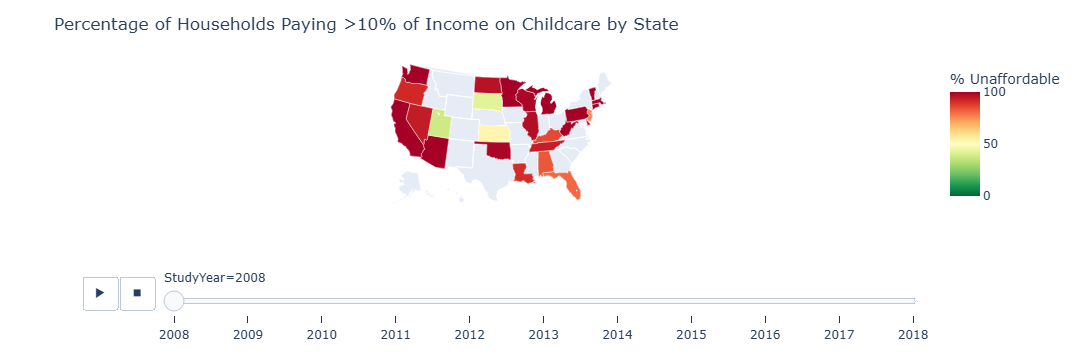

In [8]:
data['Infant_Over10'] = data['MCInfant_monthly'] > 0.1 * data['MHI_monthly']
data['Toddler_Over10'] = data['MCToddler_monthly'] > 0.1 * data['MHI_monthly']
data['Preschool_Over10'] = data['MCPreschool_monthly'] > 0.1 * data['MHI_monthly']

percent_unaffordable = data.groupby(['State_Abbreviation','StudyYear']).agg(
    Infant_Percent_Over10=('Infant_Over10', 'mean'),
    Toddler_Percent_Over10=('Toddler_Over10', 'mean'),
    Preschool_Percent_Over10=('Preschool_Over10', 'mean')
).reset_index()

percent_unaffordable[['Infant_Percent_Over10','Toddler_Percent_Over10','Preschool_Percent_Over10']] *= 100

percent_unaffordable_long = pd.melt(
    percent_unaffordable,
    id_vars=['State_Abbreviation','StudyYear'],
    value_vars=['Infant_Percent_Over10','Toddler_Percent_Over10','Preschool_Percent_Over10'],
    var_name='Childcare_Type',
    value_name='Percent_Over10'
)

percent_unaffordable_long['Percent_Over10'] = percent_unaffordable_long['Percent_Over10'].replace(0, np.nan)

percent_unaffordable_long['hover_text'] = percent_unaffordable_long.apply(
    lambda row: f"{row['State_Abbreviation']}<br>"
                f"Year: {row['StudyYear']}<br>"
                f"{row['Childcare_Type']}: "
                f"{'No Data' if pd.isna(row['Percent_Over10']) else f'{row['Percent_Over10']:.1f}%'} of households", axis=1
)

fig = px.choropleth(
    percent_unaffordable_long,
    locations='State_Abbreviation',
    locationmode='USA-states',
    color='Percent_Over10',
    hover_name='State_Abbreviation',
    hover_data={'Percent_Over10': True, 'hover_text': False},
    scope='usa',
    color_continuous_scale='RdYlGn_r',
    animation_frame='StudyYear',
    range_color=[0,100],
)

fig.update_traces(
    hovertemplate='%{customdata[0]}<extra></extra>',
    customdata=percent_unaffordable_long[['hover_text']].values,
    marker_line_width=0.5,
    marker_line_color='white'
)

fig.update_layout(
    title_text='Percentage of Households Paying >10% of Income on Childcare by State',
    coloraxis_colorbar=dict(title="% Unaffordable"),
)

fig.show()

fig.write_html("ChildcareAffordability_InteractiveMap.html")

## Infographic

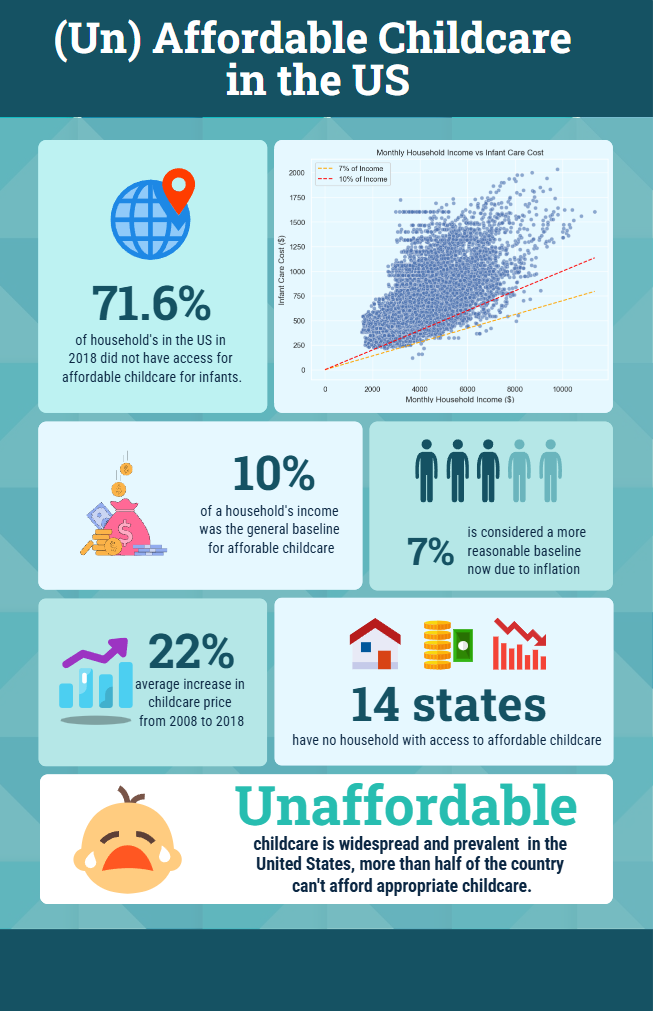

In [10]:
Image(filename='ChildcareAffordability_Infographic.PNG') 

## Graph and Plots Visualizations

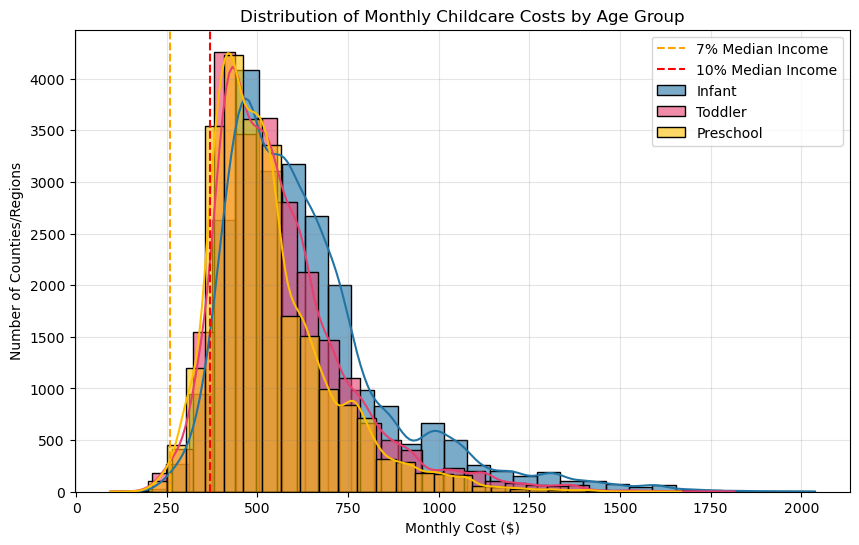

In [12]:
plt.figure(figsize=(10,6))
sb.histplot(data['MCInfant_monthly'], kde=True, color='#2274a5', label='Infant', bins=30, alpha=0.6)
sb.histplot(data['MCToddler_monthly'], kde=True, color='#e83f6f', label='Toddler', bins=30, alpha=0.6)
sb.histplot(data['MCPreschool_monthly'], kde=True, color='#ffbf00', label='Preschool', bins=30, alpha=0.6)
plt.axvline(data['MHI_monthly'].median()*0.07, color='orange', linestyle='--', label='7% Median Income')
plt.axvline(data['MHI_monthly'].median()*0.1, color='red', linestyle='--', label='10% Median Income')
plt.title('Distribution of Monthly Childcare Costs by Age Group')
plt.xlabel('Monthly Cost ($)')
plt.ylabel('Number of Counties/Regions')
plt.grid(True, color='gray', alpha=0.2)
plt.legend()
plt.show()

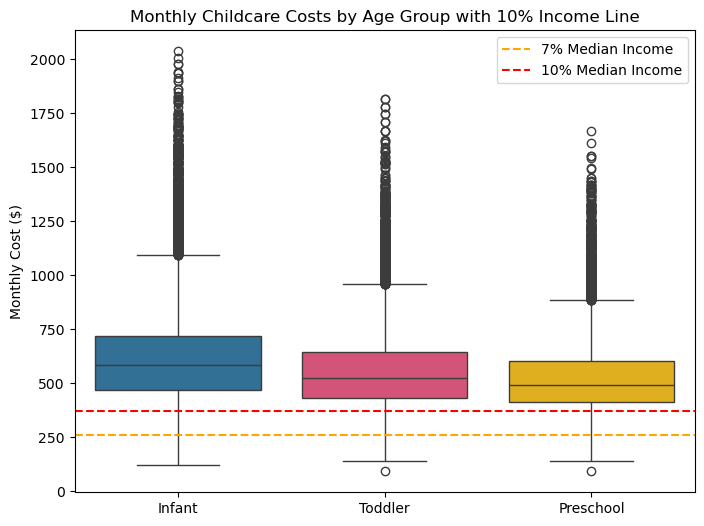

In [13]:
plt.figure(figsize=(8,6))
sb.boxplot(data=data[['MCInfant_monthly','MCToddler_monthly','MCPreschool_monthly']], palette=['#2274a5','#e83f6f','#ffbf00'])
plt.axhline(data['MHI_monthly'].median()*0.07, color='orange', linestyle='--', label='7% Median Income')
plt.axhline(data['MHI_monthly'].median()*0.1, color='red', linestyle='--', label='10% Median Income')
plt.title('Monthly Childcare Costs by Age Group with 10% Income Line')
plt.ylabel('Monthly Cost ($)')
plt.xticks([0,1,2], ['Infant','Toddler','Preschool'])
plt.legend()
plt.show()

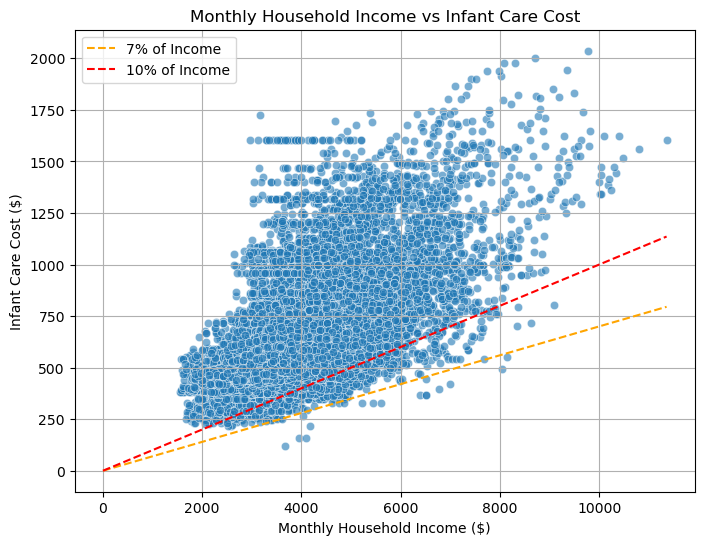

In [14]:
plt.figure(figsize=(8,6))
sb.scatterplot(data=data, x='MHI_monthly', y='MCInfant_monthly', alpha=0.6)
plt.plot([0,data['MHI_monthly'].max()], [0,data['MHI_monthly'].max()*0.07], color='orange', linestyle='--', label='7% of Income')
plt.plot([0,data['MHI_monthly'].max()], [0,data['MHI_monthly'].max()*0.1], color='red', linestyle='--', label='10% of Income')
plt.title('Monthly Household Income vs Infant Care Cost')
plt.xlabel('Monthly Household Income ($)')
plt.ylabel('Infant Care Cost ($)')
plt.grid(True)
plt.legend()
plt.show()

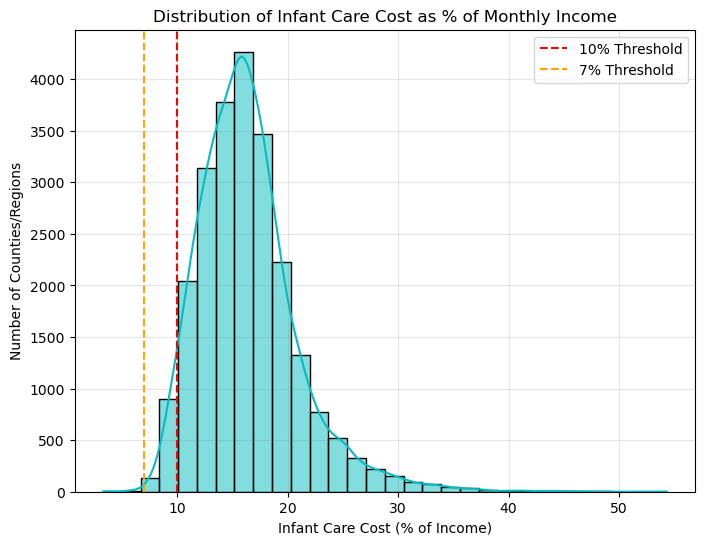

In [15]:
data['Infant_percent_income'] = data['MCInfant_monthly'] / data['MHI_monthly'] * 100
plt.figure(figsize=(8,6))
sb.histplot(data['Infant_percent_income'], bins=30, kde=True, color='#06bcc1')
plt.axvline(10, color='red', linestyle='--', label='10% Threshold')
plt.axvline(7, color='orange', linestyle='--', label='7% Threshold')
plt.title('Distribution of Infant Care Cost as % of Monthly Income')
plt.xlabel('Infant Care Cost (% of Income)')
plt.ylabel('Number of Counties/Regions')
plt.grid(True, color='gray', alpha=0.2)
plt.legend()
plt.show()

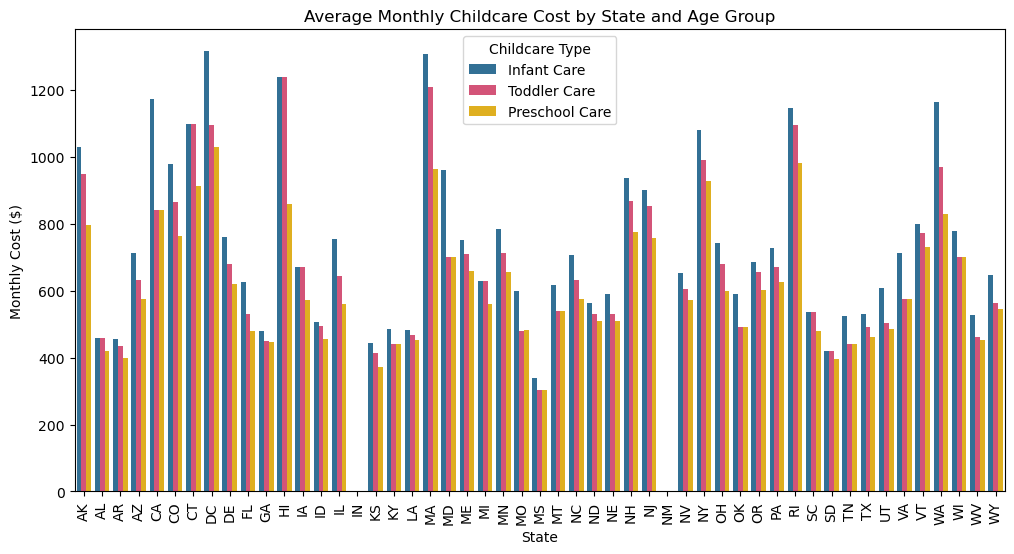

In [16]:
state_avg = data.groupby('State_Abbreviation')[['MCInfant_monthly','MCToddler_monthly','MCPreschool_monthly']].mean().reset_index()
state_avg_melted = pd.melt(state_avg, id_vars='State_Abbreviation', value_vars=['MCInfant_monthly','MCToddler_monthly','MCPreschool_monthly'],
                           var_name='Childcare_Type', value_name='Monthly_Cost')

state_avg_melted['Childcare_Type'] = state_avg_melted['Childcare_Type'].map({
    'MCInfant_monthly': 'Infant Care',
    'MCToddler_monthly': 'Toddler Care',
    'MCPreschool_monthly': 'Preschool Care'
})

plt.figure(figsize=(12,6))
sb.barplot(data=state_avg_melted, x='State_Abbreviation', y='Monthly_Cost', hue='Childcare_Type', palette=['#2274a5','#e83f6f','#ffbf00'])
plt.xticks(rotation=90)
plt.title('Average Monthly Childcare Cost by State and Age Group')
plt.ylabel('Monthly Cost ($)')
plt.xlabel('State')
plt.legend(title='Childcare Type')
plt.show()

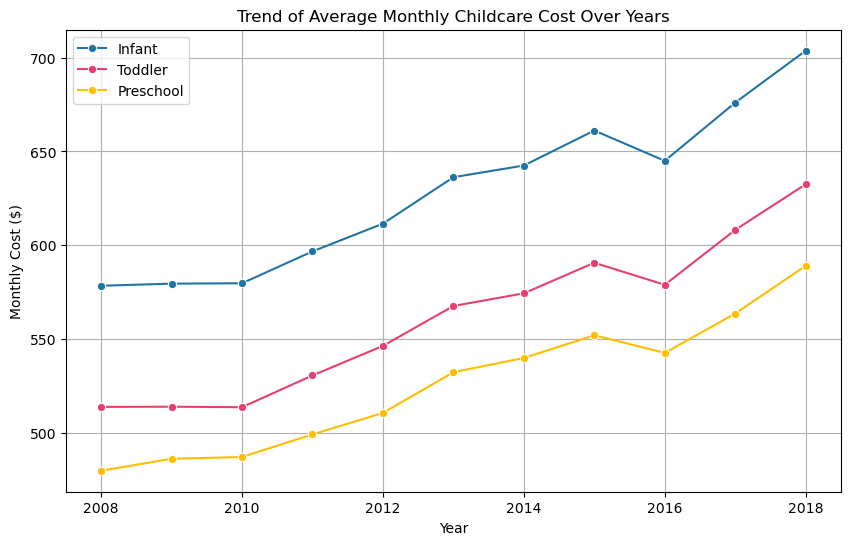

In [17]:
if 'StudyYear' in data.columns:
    yearly_avg = data.groupby('StudyYear')[['MCInfant_monthly','MCToddler_monthly','MCPreschool_monthly']].mean().reset_index()
    plt.figure(figsize=(10,6))
    sb.lineplot(data=yearly_avg, x='StudyYear', y='MCInfant_monthly', marker='o', label='Infant', color='#2274a5')
    sb.lineplot(data=yearly_avg, x='StudyYear', y='MCToddler_monthly', marker='o', label='Toddler', color='#e83f6f')
    sb.lineplot(data=yearly_avg, x='StudyYear', y='MCPreschool_monthly', marker='o', label='Preschool', color='#ffbf00')
    plt.title('Trend of Average Monthly Childcare Cost Over Years')
    plt.ylabel('Monthly Cost ($)')
    plt.xlabel('Year')
    plt.grid(True)
    plt.legend()
    plt.show()

## Paper

### Summary of Analysis

The goal of this analysis was to examine the affordability of childcare across the United 
States, using publicly available data on monthly costs of childcare for infants, toddlers, and 
preschool children. By analyzing available state-level data and comparing the averages to 
standard affordability thresholds, which were typically 10% of a family's income but have 
recently been lowered to 7%, we can see that in most of the country, families are paying 
disproportionately high percentages of their income for childcare.

### Findings 

The analysis shows that the vast majority of families face unaffordable childcare costs. 
Almost no states have childcare available below the 7% income benchmark, and very few have 
childcare available within the 10% threshold. This trend is consistent across infant, toddler, and 
preschool childcare, with infants being the most expensive of the three. While some areas offer 
affordable childcare, the current norm is that in most of the country, affordable childcare is not 
readily available, and childcare costs are rapidly increasing.

### Assumptions

The findings assume that the dataset is accurate and representative of the population. 
Although the data is somewhat out of date, as the latest data is from 2018, it is assumed that 
these increasing trends have continued, following previous trends. 

Several factors still require clarification, as it is unclear whether this data includes 
discounts from government assistance programs or whether all costs are out-of-pocket. 

Additionally, it's unclear whether the data contains full-time childcare or also part-time childcare, as this could affect the cost analysis. Many individuals may not be able to afford full-time 
childcare, which could lead to childcare being even more expensive than found in the analysis. 

### Direction of Story

The primary message of this project is that childcare in the United States is largely 
unaffordable for most of the population, and little is being done to address the issues. Childcare 
costs continue to rise, while wages remain stagnant, leading to an increasing number of families 
struggling to afford childcare. This project highlights the lack of affordable childcare. It 
demonstrates that it's essentially a luxury for most of the country, aiming to encourage policy 
changes and raise awareness about an issue that is often overlooked. 

### Target Audience 

The target audience is primarily parents and families seeking affordable childcare, as well 
as policymakers and government agencies that address childcare affordability. The goal is to 
inform these families and encourage them to advocate for policy changes, so that policymakers 
realize the impact they are having on millions of families by doing nothing about it.

### Mediums

I included three different mediums in this project:
- Interactive map: Allows users to explore state childcare costs and compare them to 
income benchmarks. This helps parents and policymakers quickly identify areas of concern and 
view the trends of these costs over the past years.

- Infographic: Provides a concise visual summary of key findings and affordability issues, 
making it ideal for social media or public awareness campaigns, as it's easy to read and conveys 
general knowledge of the problem at hand.


- Technical report: This document includes detailed charts and statistical analysis to 
support the findings and provide a more comprehensive understanding of the data for 
policymakers or other technical audiences interested in the analytical aspects.

### Design Decisions 

Visualizations were designed to highlight differences in childcare costs across age groups 
and states. Color coding was used to differentiate between infant, toddler, and preschool 
childcare.  

The interactive map utilizes a slider to visualize the progression of the percentage of 
people in each state who fall within the affordability thresholds. This is illustrated through a 
green-to-red gradient, making the data easy to understand at a glance. Additional information on 
each state is provided when the mouse hovers over it.  

The infographic was designed to convey key information on the topic while remaining 
easy to understand and aesthetically pleasing to capture readers' attention.  

The plots were meant to be more technical than the interactive map, while still being easy 
to read and understand the data being presented. Benchmark lines are also included to indicate 
affordability thresholds within specific plots.

### Ethical Considerations 

Only minor changes were made to the data, primarily for cleaning and formatting 
purposes, to make the data more accessible and easier to work with. 

There are no legal or regulatory guidelines for the data in my project, as it's all publicly available 
data from government agencies on childcare costs. 

There are no risks associated with the visualizations or the way the data is presented. The 
project clearly illustrates how unaffordable childcare has become and how it's likely to continue 
increasing in the coming years if no action is taken. 

I didn't make any assumptions about the data other than that the cost is likely to continue 
rising from the last year of the data, based on the trends seen in the previous years of the data. 
While some things still need clarification, the data was used and presented as it was in the 
datasets. 

My data was sourced from the National Database of Childcare Prices, a government 
entity, so the data is likely to be accurate and credible. 

There are no significant ethical implications associated with my project, so there’s little to 
mitigate. 

### Further Improvements

Next time, I would like to use more recent data to conduct my analysis; however, this 
new analysis would likely be different due to events such as the COVID-19 pandemic, which 
may have resulted in a drop in childcare costs as many individuals were quarantined at home 
without the need to pay for childcare. 